In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 1. Loading Libraries

In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import Counter
from itertools import cycle                   
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
tqdm.pandas()

from autocorrect import Speller
from textblob import TextBlob
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, RocCurveDisplay

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. Load Data

In [3]:
data = pd.read_csv('../Dataset/wiki_movie_plots_deduped.csv', engine='python', encoding='utf-8')
data.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


# 3. Initial Analysis

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


In [5]:
data['Origin/Ethnicity'].value_counts()

American        17377
British          3670
Bollywood        2931
Tamil            2599
Telugu           1311
Japanese         1188
Malayalam        1095
Hong Kong         791
Canadian          723
Australian        576
South_Korean      522
Chinese           463
Kannada           444
Bengali           306
Russian           232
Marathi           141
Filipino          128
Bangladeshi        87
Punjabi            84
Malaysian          70
Turkish            70
Egyptian           67
Assamese            9
Maldivian           2
Name: Origin/Ethnicity, dtype: int64

In [6]:
data = data[(data['Origin/Ethnicity'] == 'American') | (data['Origin/Ethnicity'] == 'British') | ( data['Origin/Ethnicity'] == 'Bollywood')| ( data['Origin/Ethnicity'] == 'Tamil')]
data = data[data['Genre'] != 'unknown']
data

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...
10,1906,Dream of a Rarebit Fiend,American,Wallace McCutcheon and Edwin S. Porter,NaN,short,https://en.wikipedia.org/wiki/Dream_of_a_Rareb...,The Rarebit Fiend gorges on Welsh rarebit at a...
11,1906,From Leadville to Aspen: A Hold-Up in the Rockies,American,Francis J. Marion and Wallace McCutcheon,NaN,short action/crime western,https://en.wikipedia.org/wiki/From_Leadville_t...,The film features a train traveling through th...
12,1906,Kathleen Mavourneen,American,Edwin S. Porter,NaN,short film,https://en.wikipedia.org/wiki/Kathleen_Mavourn...,Irish villager Kathleen is a tenant of Captain...
...,...,...,...,...,...,...,...,...
31486,2017,Sathya,Tamil,Pradeep Krishnamoorthy,"Sibi Sathyaraj, Remya Nambeesan, Varalaxmi Sar...",crime thriller,https://en.wikipedia.org/wiki/Sathya_(2017_Tam...,"Sathya (Sibi Sathyaraj), Who is working in Syd..."
31487,2017,Maayavan,Tamil,C. V. Kumar,"Sundeep Kishan, Lavanya Tripathi, Daniel Balaj...",action drama,https://en.wikipedia.org/wiki/Maayavan,The film starts with the death of a renowned n...
31488,2017,Aruvi,Tamil,Arun Prabu Purushothaman,"Aditi Balan, Lakshmi Gopalswami, Shwetha Shekar",social drama,https://en.wikipedia.org/wiki/Aruvi,The film begins with Aruvi (Aditi Balan) and E...
31489,2017,Chennai 2 Singapore,Tamil,Abbas Akbar,"Gokul Anand, Rajesh Balachandiran, Anju Kurian",romantic comedy,https://en.wikipedia.org/wiki/Chennai2Singapore,The film is a comedy about a struggling Indian...


In [7]:
data['Genre'].value_counts()

drama                                4716
comedy                               3937
horror                                997
western                               860
thriller                              784
                                     ... 
action, adventure, sci-fi               1
romance, horror, thriller               1
comedy, action, crime                   1
action, adventure, drama, fantasy       1
fantasy adventure comedy                1
Name: Genre, Length: 1388, dtype: int64

In [8]:
value_counts_df = data['Genre'].value_counts().reset_index()
value_counts_df.columns = ['name', 'count']
value_counts_df.to_csv("value_counts_df.csv")
value_counts_df

,name,count
0,drama,4716
1,comedy,3937
2,horror,997
3,western,860
4,thriller,784
...,...,...
1383,"action, adventure, sci-fi",1
1384,"romance, horror, thriller",1
1385,"comedy, action, crime",1
1386,"action, adventure, drama, fantasy",1


In [9]:
shortlisted_genres = data["Genre"].value_counts().reset_index(name="count").query("count >2000")["index"].tolist()
shortlisted_genres

['drama', 'comedy']

In [11]:
data = data[data['Genre'].isin(shortlisted_genres)].reset_index(drop=True)
data

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...
1,1907,How Brown Saw the Baseball Game,American,Unknown,Unknown,comedy,https://en.wikipedia.org/wiki/How_Brown_Saw_th...,Before heading out to a baseball game at a nea...
2,1907,Laughing Gas,American,Edwin Stanton Porter,"Bertha Regustus, Edward Boulden",comedy,https://en.wikipedia.org/wiki/Laughing_Gas_(fi...,The plot is that of a black woman going to the...
3,1908,The Adventures of Dollie,American,D. W. Griffith,"Arthur V. Johnson, Linda Arvidson",drama,https://en.wikipedia.org/wiki/The_Adventures_o...,On a beautiful summer day a father and mother ...
4,1908,The Black Viper,American,D. W. Griffith,D. W. Griffith,drama,https://en.wikipedia.org/wiki/The_Black_Viper,A thug accosts a girl as she leaves her workpl...
...,...,...,...,...,...,...,...,...
8648,2017,Peechankai,Tamil,Ashok,"R. S. Karthik, Anjali Rao, Vivek Prasanna, M. ...",comedy,https://en.wikipedia.org/wiki/Peechankai,Smoodhu is a famous left handed pickpocket and...
8649,2017,Kootathil Oruthan,Tamil,T. J. Gnanavel,"Ashok Selvan, Priya Anand, Samuthirakani",drama,https://en.wikipedia.org/wiki/Kootathil_Oruthan,"Arvind, an ordinary Joe who is not noticed by ..."
8650,2017,Podhuvaga En Manasu Thangam,Tamil,Thalapathy Prabhu,"Udhayanidhi Stalin, Nivetha Pethuraj, Parthiep...",comedy,https://en.wikipedia.org/wiki/Podhuvaga_En_Man...,Two nearby villages in the southern suburbs of...
8651,2017,Magalir Mattum,Tamil,Bramma,"Jyothika, Saranya, Urvashi, Bhanupriya",drama,https://en.wikipedia.org/wiki/Magalir_Mattum_(...,Prabhavathi (Jyothika) is a feisty independent...


Text(0.5, 1.0, 'Rating Distribution Across Dataset')

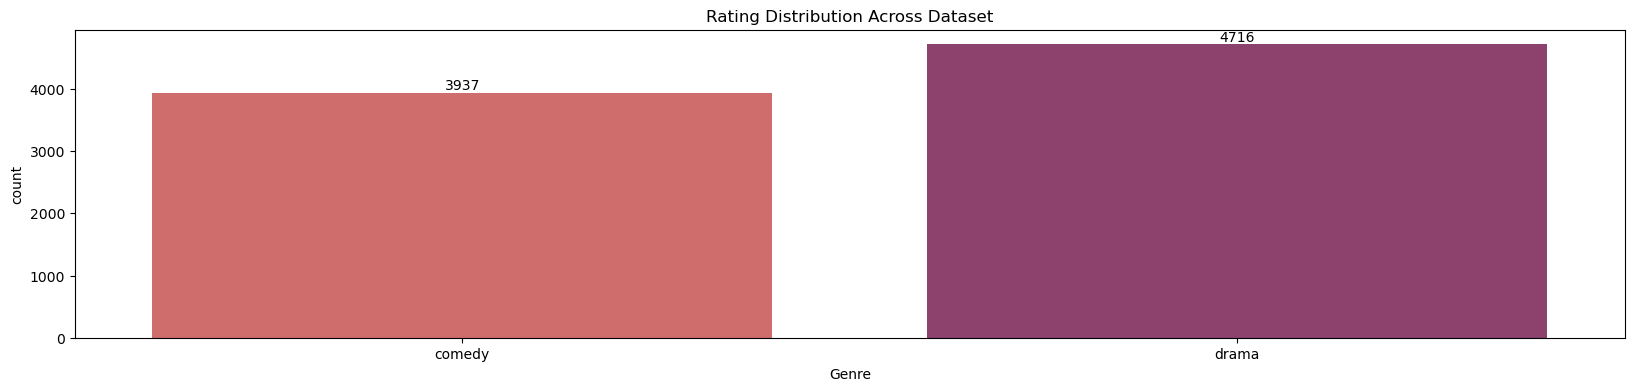

In [12]:
plt.subplots(figsize = (20,4))
ax = sns.countplot(data = data, x = 'Genre', palette='flare')
ax.bar_label(ax.containers[0])
ax.set_title('Rating Distribution Across Dataset')

# 4. Preprocessing Text

### 4.1. Labeling

In [6]:
data['label'] = data['Rating'].map({1 : 0, 
                                    2 : 0, 
                                    3 : 0, 
                                    4 : 1, 
                                    5 : 2})
data.head()

,Review,Rating,label
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,0
3,"unique, great stay, wonderful time hotel monac...",5,2
4,"great stay great stay, went seahawk game aweso...",5,2


### 4.4. Cleaning combined_text Column

In [14]:
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

def lower_text(text):
    return text.lower()

def clean_text(text):
    text = re.sub("[^a-z0-9\s]","", text)
    # text = re.sub(r'__[^\s]*_', '', text)
    # text = re.sub(CLEANR, '', text)
    # text = re.sub(r'http\S+', '', text)
    # text = re.sub(r'www\S+', '', text)
    # text = re.sub("#+"," ", text)
    # text = re.sub("@[\w]*"," ", text)
    # text = re.sub("@[A-Za-z0-9_]+"," ", text)
    return text

def remove_duplicate_words(text):
    return re.sub(r'\b(\w+)(\s+\1)+\b', r'\1', text)

def lemmatizer(text):
    sentence = []
    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))
    return ''.join(sentence)

stopword_en = pd.read_csv('../../en_stopword_1555.txt', header=None).drop_duplicates()
en_stopword = stopword_en[0].values.tolist()
en_stopword = [word.strip() for word in en_stopword]

nltk_stopword = stopwords.words('english')

combined_stopwords = pd.DataFrame(en_stopword + nltk_stopword).drop_duplicates()
stopword_list = combined_stopwords[0].values.tolist()

In [15]:
data['clean_text'] = data['Plot'] \
                    .progress_apply(clean_text) \
                    .progress_apply(lambda x: ' '.join([word for word in x.split() if word not in (nltk_stopword)]))
                    # .progress_apply(lemmatizer)
                    # .progress_apply(lambda x: ' '.join([word for word in x.split() if len(word) >= 4]))
                    # .progress_apply(remove_duplicate_words) \

data.head()

  0%|          | 0/8653 [00:00<?, ?it/s]

  0%|          | 0/8653 [00:00<?, ?it/s]

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,clean_text
0,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...,film family move suburbs hoping quiet life thi...
1,1907,How Brown Saw the Baseball Game,American,Unknown,Unknown,comedy,https://en.wikipedia.org/wiki/How_Brown_Saw_th...,Before heading out to a baseball game at a nea...,heading baseball game nearby ballpark sports f...
2,1907,Laughing Gas,American,Edwin Stanton Porter,"Bertha Regustus, Edward Boulden",comedy,https://en.wikipedia.org/wiki/Laughing_Gas_(fi...,The plot is that of a black woman going to the...,plot black woman going dentist toothache given...
3,1908,The Adventures of Dollie,American,D. W. Griffith,"Arthur V. Johnson, Linda Arvidson",drama,https://en.wikipedia.org/wiki/The_Adventures_o...,On a beautiful summer day a father and mother ...,beautiful summer day father mother take daught...
4,1908,The Black Viper,American,D. W. Griffith,D. W. Griffith,drama,https://en.wikipedia.org/wiki/The_Black_Viper,A thug accosts a girl as she leaves her workpl...,thug accosts girl leaves workplace man rescues...


In [16]:
data['clean_text'].values

array(['film family move suburbs hoping quiet life things start go wrong wife gets violent starts throwing crockery leading arrest',
       'heading baseball game nearby ballpark sports fan mr brown drinks several highball cocktails arrives ballpark watch game become inebriated game appears reverse players running bases backwards baseball flying back pitchers hand game mr brown escorted home one friends arrive browns house encounter wife becomes furious friend proceeds physically assault believing responsible husbands severe intoxication1',
       'plot black woman going dentist toothache given laughing gas way walking home situations cant stop laughing everyone meets catches laughter including vendor police officers',
       ...,
       'two nearby villages southern suburbs theni share god kula dheivam idol shared festivals oothukattaan rich big shot village grudge village insulted long time ago since promised keep gods idol village forever order destroy neighboring village plans evac

### 4.5. Reduce the sentence to be processed according to the desired number of words

<Axes: xlabel='text_len'>

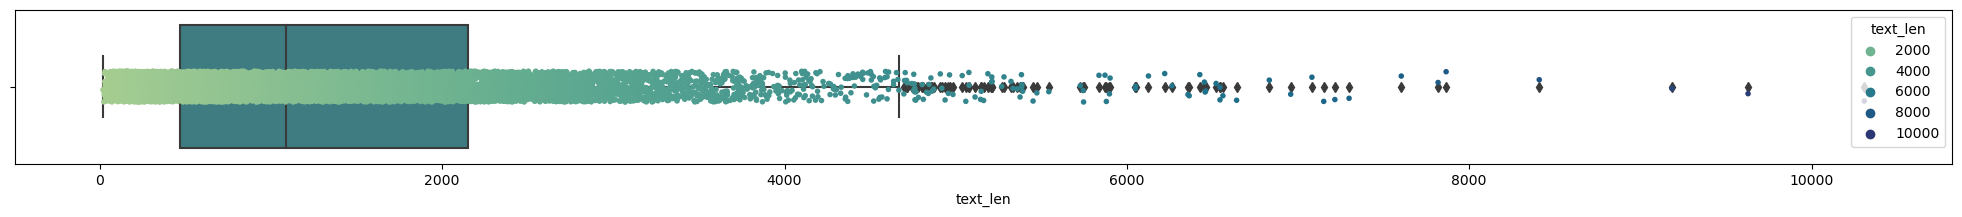

In [17]:
text_len = []

for idx, teks in enumerate(data['clean_text']):
    text_len.append(len(teks))
data['text_len'] = pd.DataFrame(text_len)

fig, ax = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="crest")

sns.stripplot(x=data['text_len'], data=data,
              size=4, color=".3", linewidth=0, palette="crest", hue=data['text_len'])

In [18]:
print(data['text_len'].quantile(0.25))
print(data['text_len'].quantile(0.75))

469.0
2149.0


469.0
2149.0


<Axes: xlabel='text_len'>

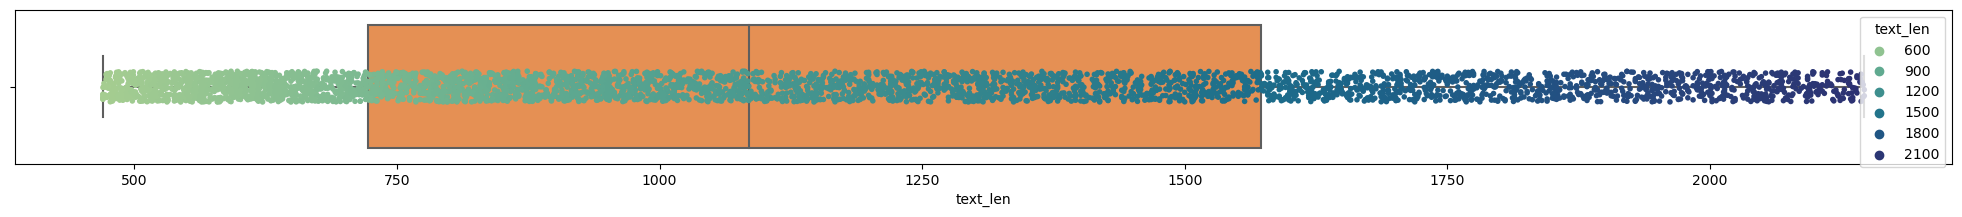

In [19]:
Q1 = data['text_len'].quantile(0.25)
Q3 = data['text_len'].quantile(0.75)

print(Q1)
print(Q3)

data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="Oranges")

sns.stripplot(x=data['text_len'], data=data,
              size=4, color=".3", linewidth=0, palette="crest", hue=data['text_len'])

### 4.6. Visualize # of label after preprocessing

[Text(0, 0, '2491'), Text(0, 0, '1832')]

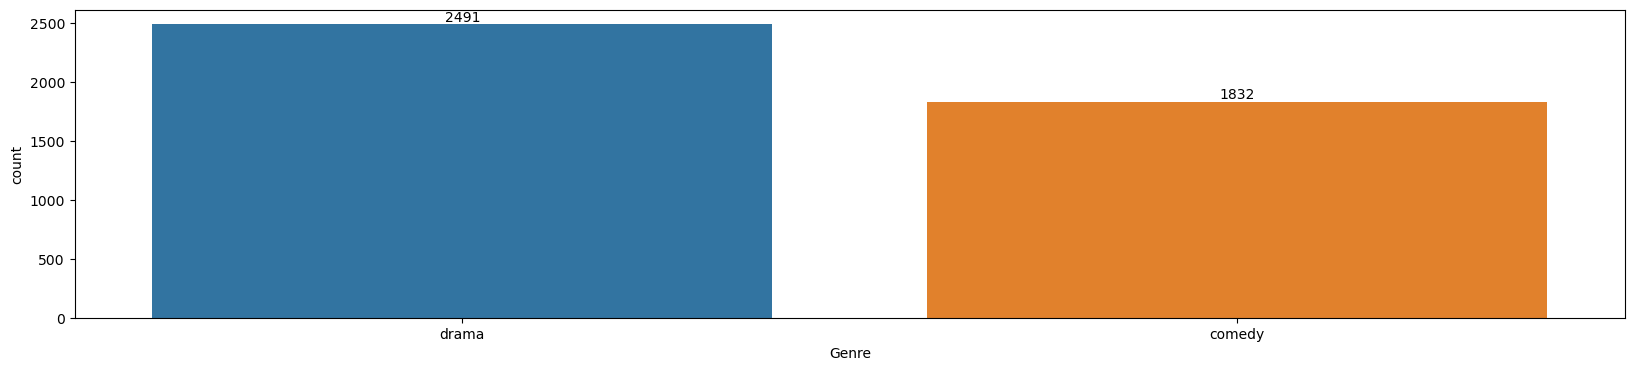

In [20]:
plt.subplots(figsize = (20,4))
ax = sns.countplot(data = data, x = 'Genre')
ax.bar_label(ax.containers[0])

# 5. Model

### 5.1. Splitting data into Training, Testing, and Validating data

In [21]:
encoder = LabelEncoder()
genre = encoder.fit_transform(data['Genre'])

X = data['clean_text']
Y = to_categorical(genre)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(3034,)
(856,)
(433,)


### 5.2. Declare parameter for Tokenizing and Training Model process

In [22]:
vocab_size = 10000
embedding_dim = 128
max_length = 2200
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

### 5.3. Tokenizing text

In [30]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
# training_padded = np.array(training_padded)
# training_label = np.array(y_train)

# testing_padded = np.array(testing_padded)
# testing_label = np.array(y_test)

# validating_padded = np.array(validating_padded)
# validating_label = np.array(y_val)

55883


In [23]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

# Undersampling
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable

training_padded, training_label = rus.fit_resample(training_padded, training_label)
testing_padded, testing_label = rus.fit_resample(testing_padded, testing_label)
validating_padded, validating_label = rus.fit_resample(validating_padded, validating_label)

# training_label = to_categorical(training_label)
# testing_label = to_categorical(testing_label)
# validating_label = to_categorical(validating_label)

print(len(training_label))
print(len(testing_label))
print(len(validating_label))


50139
2544
750
370


### 5.4. Build Deep Learning Models

In [25]:
def CNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

    model.add(Conv1D(64, 5, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    # model.add(Dropout(0.8))
    model.add(MaxPooling1D())

    # model.add(Conv1D(64, 5, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    # model.add(BatchNormalization())
    # # model.add(LeakyReLU(0.2))
    # model.add(ReLU())
    # model.add(Dropout(0.5))
    # model.add(MaxPooling1D())

    model.add(Conv1D(32, 5, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    # model.add(Dropout(0.5))
    model.add(MaxPooling1D())

    model.add(Conv1D(15, 5, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    # model.add(Dropout(0.5))
    model.add(MaxPooling1D())

    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(32, activation='swish'))
    model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    # model.add(Bidirectional(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True)))
    model.add(Bidirectional(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model
    

# model = CNN_Model()
# model = LSTM_Model()
model = GRU_Model()

model.summary()

# opt = RMSprop(learning_rate = 0.001)
# opt = SGD(learning_rate = 0.001)
opt = Adam(learning_rate = 0.0005)

# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[tf.keras.metrics.AUC()])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2200, 128)         1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              198144    
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,511,169
Trainable params: 1,511,169
Non-trainable params: 0
_________________________________________________________________


### 5.5. Training the Model

In [28]:
num_epoch = 10
batch_size = 16

history = model.fit(training_padded, training_label, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (testing_padded, testing_label))

Epoch 1/10
159/159 [==============================] - 42s 263ms/step - loss: 0.1245 - accuracy: 0.9579 - val_loss: 1.1451 - val_accuracy: 0.6320
Epoch 2/10
159/159 [==============================] - 41s 260ms/step - loss: 0.0649 - accuracy: 0.9784 - val_loss: 1.6913 - val_accuracy: 0.6133
Epoch 3/10
159/159 [==============================] - 42s 266ms/step - loss: 0.0084 - accuracy: 0.9976 - val_loss: 1.9405 - val_accuracy: 0.6120
Epoch 4/10
134/159 [========================>.....] - ETA: 5s - loss: 0.0068 - accuracy: 0.9991

# 6. Evaluating Performance

### 6.21. Plotting Accuracy and Loss of the Model

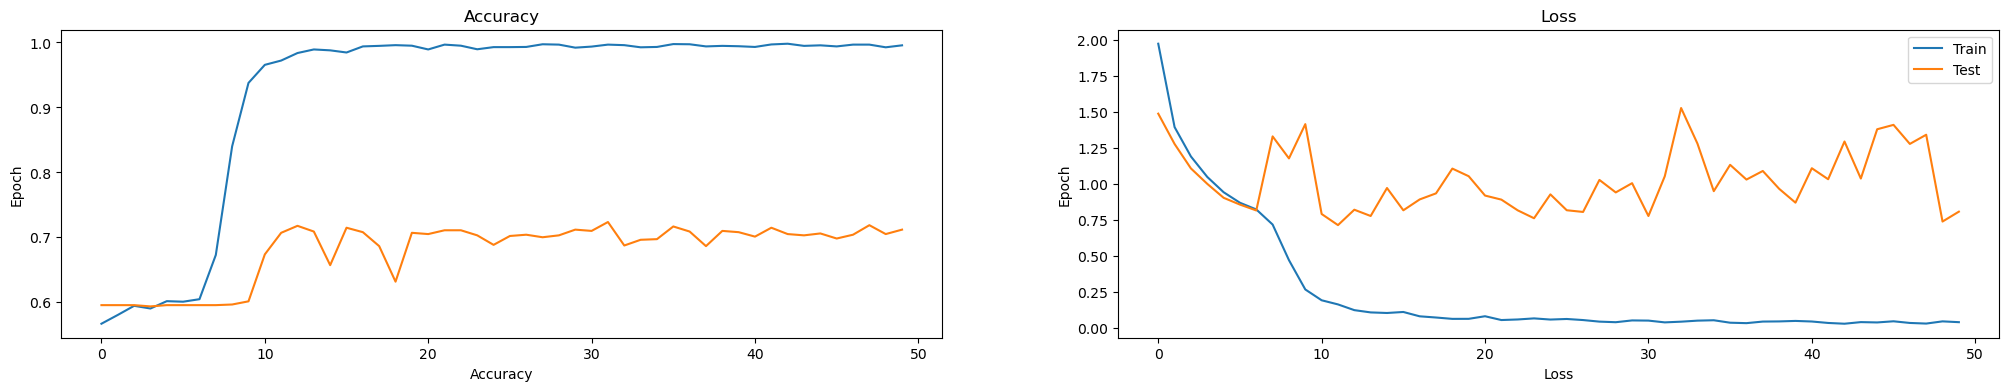

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 4))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

### 6.2. Confusion Matrix

18/18 [==============================] - 2s 59ms/step


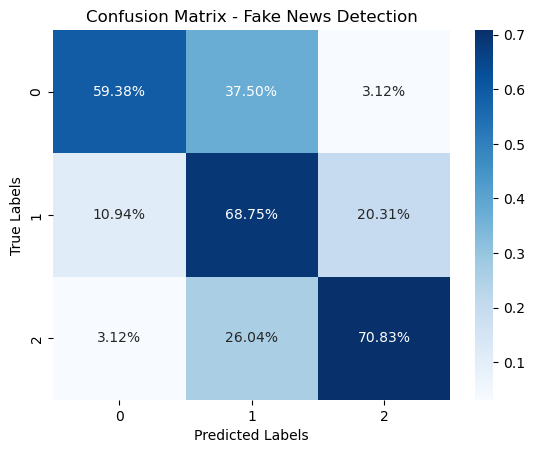

In [28]:
# labels = ['No Fraud', 'Fraud']

y_pred = np.rint(model.predict(validating_padded))
# Build confusion matrix
con_mat = confusion_matrix(validating_label.argmax(axis=1),y_pred.argmax(axis=1))

# Compute the percentages for the confusion matrix
cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

# Create the heatmap using Seaborn
# sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')

# Add labels to the plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

In [23]:
from sklearn.metrics import classification_report
y_pred = np.rint(model.predict(validating_padded))

print(classification_report(validating_label.argmax(axis=1),y_pred.argmax(axis=1)))

18/18 [==============================] - 1s 60ms/step
              precision    recall  f1-score   support

           0       0.72      0.62      0.67       192
           1       0.51      0.70      0.59       192
           2       0.81      0.61      0.70       192

    accuracy                           0.65       576
   macro avg       0.68      0.65      0.65       576
weighted avg       0.68      0.65      0.65       576



### 6.3. ROC Curve 

18/18 [==============================] - 1s 58ms/step


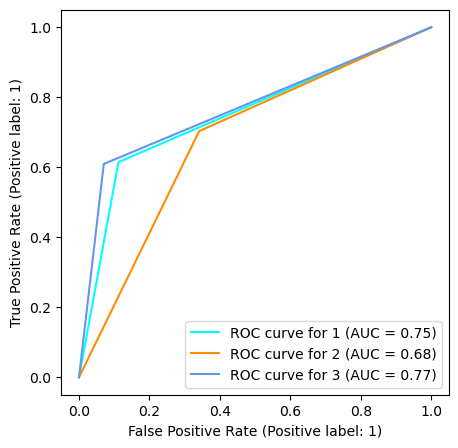

In [24]:
y_pred = np.rint(model.predict(validating_padded))
n_classes = 3

fig, ax = plt.subplots(figsize=(5, 5))
# target_names = ['1', '2', '3', '4', '5']
target_names = ['1', '2', '3']

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        validating_label[:, class_id],
        y_pred[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )